# CPPN e GAN

Esse notebook realiza APENAS o treinamento da CPPN utilizando a GAN.

# Bibliotecas

In [1]:
!pip install torch scikit-image

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import time
from tqdm import tqdm
from skimage.draw import polygon

# Dados de entrada:

Carregar a biblioteca contendo as simulações do CST, calcular a trasmitância e a fase em TE e TM e criar um dataframe.


Nanopilares Elipticos:

In [5]:
DEFAULT_HEIGHT = 600.0
DEFAULT_ANGLE = 0.0
IMG_SIZE = 64
MAX_DIM_NM = 520

def processar_pkl(caminho):
    """
    Função auxiliar para carregar, filtrar e processar um .pkl
    """
    if not os.path.exists(caminho):
        print(f"--- ERRO: Arquivo NÃO encontrado ---")
        print(f"Verifique o caminho: '{caminho}'")
        return None

    try:
        df_real = pd.read_pickle(caminho)
        print(f"Carregada: '{caminho}'. Forma inicial: {df_real.shape}")

        if 'S24_real' not in df_real.columns or 'S13_real' not in df_real.columns:
            raise KeyError("Colunas 'S24_real' ou 'S13_real' não encontradas.")

        df_real['S_complex_TM'] = df_real['S24_real'] + 1j * df_real['S24_imag']
        df_real['S_complex_TE'] = df_real['S13_real'] + 1j * df_real['S13_imag']

        df_filtrado_2D = df_real[
            (df_real['H'] == DEFAULT_HEIGHT) &
            (df_real['a'] == DEFAULT_ANGLE) &
            (df_real['L_x'] % 5 == 0) &
            (df_real['L_y'] % 5 == 0)
        ].copy()

        print(f"Filtrada para 2D. Nova forma: {df_filtrado_2D.shape}")

        if df_filtrado_2D.shape[0] == 0:
            raise ValueError("Filtragem resultou em 0 átomos.")

        df_filtrado_2D['Transmitancia_x'] = np.abs(df_filtrado_2D['S_complex_TM'])
        df_filtrado_2D['Fase_x'] = np.angle(df_filtrado_2D['S_complex_TM'])
        df_filtrado_2D['Transmitancia_y'] = np.abs(df_filtrado_2D['S_complex_TE'])
        df_filtrado_2D['Fase_y'] = np.angle(df_filtrado_2D['S_complex_TE'])

        return df_filtrado_2D

    except Exception as e:
        print(f"Ocorreu um erro ao processar '{caminho}': {e}")
        return None

# --- Função 2: Processamento de Elipses (MODIFICADA) ---
def processar_elipses_pkl(caminho):
    """
    Função auxiliar para carregar e processar 7lib.pkl,
    MANTENDO AS ROTAÇÕES (coluna 'a').
    """
    if not os.path.exists(caminho):
        print(f"--- ERRO: Arquivo NÃO encontrado ---")
        return None
    try:
        df_real = pd.read_pickle(caminho)
        print(f"Carregada: '{caminho}'. Forma inicial: {df_real.shape}")

        if 'S24_real' not in df_real.columns or 'S13_real' not in df_real.columns:
            raise KeyError("Colunas 'S24_real' ou 'S13_real' não encontradas.")

        df_real['S_complex_TM'] = df_real['S24_real'] + 1j * df_real['S24_imag']
        df_real['S_complex_TE'] = df_real['S13_real'] + 1j * df_real['S13_imag']

        # FILTRAGEM MODIFICADA: Remove o filtro 'a == 0'
        df_filtrado_2D = df_real[
            (df_real['H'] == DEFAULT_HEIGHT) &
            # (df_real['a'] == DEFAULT_ANGLE) & <-- LINHA REMOVIDA
            (df_real['L_x'] % 5 == 0) &
            (df_real['L_y'] % 5 == 0)
        ].copy()

        print(f"Filtrada para 2D (H=600). Nova forma: {df_filtrado_2D.shape}")

        if df_filtrado_2D.shape[0] == 0:
            raise ValueError("Filtragem resultou em 0 átomos.")

        df_filtrado_2D['Transmitancia_x'] = np.abs(df_filtrado_2D['S_complex_TM'])
        df_filtrado_2D['Fase_x'] = np.angle(df_filtrado_2D['S_complex_TM'])
        df_filtrado_2D['Transmitancia_y'] = np.abs(df_filtrado_2D['S_complex_TE'])
        df_filtrado_2D['Fase_y'] = np.angle(df_filtrado_2D['S_complex_TE'])
        return df_filtrado_2D
    except Exception as e:
        print(f"Ocorreu um erro ao processar '{caminho}': {e}")
        return None

# --- Função 3: Processamento de Polígonos (NOVA) ---
def processar_poligonos_pkl(caminho):
    """
    Função adaptada para carregar os dados de POLÍGONOS.
    Ela filtra H=600, mas NÃO filtra a rotação 'a'.
    """
    if not os.path.exists(caminho):
        print(f"--- ERRO: Arquivo NÃO encontrado ---")
        return None
    try:
        df_real = pd.read_pickle(caminho)
        print(f"Carregada: '{caminho}'. Forma inicial: {df_real.shape}")

        if 'S24_real' not in df_real.columns or 'S13_real' not in df_real.columns:
            raise KeyError("Colunas 'S24_real' ou 'S13_real' não encontradas.")

        df_real['S_complex_TM'] = df_real['S24_real'] + 1j * df_real['S24_imag']
        df_real['S_complex_TE'] = df_real['S13_real'] + 1j * df_real['S13_imag']

        # FILTRAGEM NOVA: Apenas 'H'
        df_filtrado_2D = df_real[
            (df_real['H'] == DEFAULT_HEIGHT)
        ].copy()

        print(f"Filtrada para 2D (H=600). Nova forma: {df_filtrado_2D.shape}")

        if df_filtrado_2D.shape[0] == 0:
            raise ValueError("Filtragem resultou em 0 átomos.")

        df_filtrado_2D['Transmitancia_x'] = np.abs(df_filtrado_2D['S_complex_TM'])
        df_filtrado_2D['Fase_x'] = np.angle(df_filtrado_2D['S_complex_TM'])
        df_filtrado_2D['Transmitancia_y'] = np.abs(df_filtrado_2D['S_complex_TE'])
        df_filtrado_2D['Fase_y'] = np.angle(df_filtrado_2D['S_complex_TE'])
        return df_filtrado_2D
    except Exception as e:
        print(f"Ocorreu um erro ao processar '{caminho}': {e}")
        return None

Transformar o meta átomo em uma imagem 64x64 para que a rede consiga tratá-lo.

In [6]:
IMG_SIZE = 64 # 64x64 pixels
MAX_DIM_NM = 520 # O tamanho físico total da célula unitária

# Função de Desenho 1: ELIPSE
def draw_meta_atom_ellipse(L_x_nm, L_y_nm, a_deg):
    """
    Desenha um meta-átomo de ELIPSE ROTACIONADA como um array numpy binário.
    """
    scale_factor = IMG_SIZE / MAX_DIM_NM
    a_px = L_x_nm * scale_factor # Raio semi-eixo X
    b_px = L_y_nm * scale_factor # Raio semi-eixo Y

    if a_px == 0 or b_px == 0:
        return np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.float32)

    x = np.arange(0, IMG_SIZE)
    y = np.arange(0, IMG_SIZE)
    xx, yy = np.meshgrid(x, y)
    center = (IMG_SIZE - 1) / 2.0

    # --- Início da Rotação ---
    a_rad = np.deg2rad(a_deg)
    cos_a = np.cos(a_rad)
    sin_a = np.sin(a_rad)

    # Coordenadas centradas
    x_c = xx - center
    y_c = yy - center

    # Aplicar matriz de rotação inversa às coordenadas
    # (x' = x*cos + y*sin, y' = -x*sin + y*cos)
    x_rot = x_c * cos_a + y_c * sin_a
    y_rot = -x_c * sin_a + y_c * cos_a

    # Equação da elipse com coordenadas rotacionadas
    term_x = (x_rot / a_px) ** 2
    term_y = (y_rot / b_px) ** 2
    mask = (term_x + term_y) <= 1
    # --- Fim da Rotação ---

    img = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.float32)
    img[mask] = 1.0
    return img

# Função de Desenho 2: RETÂNGULO
def draw_meta_atom_rectangle(X_nm, Y_nm):
    """
    Desenha um meta-átomo de RETÂNGULO como um array numpy binário.
    """
    scale_factor = IMG_SIZE / MAX_DIM_NM
    width_px = X_nm * scale_factor
    height_px = Y_nm * scale_factor

    if width_px == 0 or height_px == 0:
        return np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.float32)

    x = np.arange(0, IMG_SIZE)
    y = np.arange(0, IMG_SIZE)
    xx, yy = np.meshgrid(x, y)
    center = (IMG_SIZE - 1) / 2.0

    x_min = center - width_px / 2.0
    x_max = center + width_px / 2.0
    y_min = center - height_px / 2.0
    y_max = center + height_px / 2.0

    mask_x = (xx >= x_min) & (xx <= x_max)
    mask_y = (yy >= y_min) & (yy <= y_max)
    mask = mask_x & mask_y

    img = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.float32)
    img[mask] = 1.0
    return img

def draw_meta_atom_polygon(b, a_deg, R_nm):
    """
    Desenha um meta-átomo de POLÍGONO regular como um array numpy binário.
    - b: Número de lados/vértices (ex: 3, 4, 5...)
    - a_deg: Ângulo de rotação em graus (ex: 0, 22.5, 45)
    - R_nm: Raio do círculo circunscrito (em nanômetros)
    """
    scale_factor = IMG_SIZE / MAX_DIM_NM

    R_px = R_nm * scale_factor
    center = (IMG_SIZE - 1) / 2.0
    a_rad = np.deg2rad(a_deg)

    vert_x = []
    vert_y = []

    for i in range(b):
        angle = (2 * np.pi * i / b) + a_rad
        vx = center + R_px * np.cos(angle)
        vy = center + R_px * np.sin(angle)
        vert_x.append(vx)
        vert_y.append(vy)

    img = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.float32)

    # skimage.draw.polygon calcula os pixels DENTRO dos vértices
    # A ordem é (linha, coluna) ou (y, x)
    rr, cc = polygon(vert_y, vert_x)

    # Garante que os índices estão dentro dos limites da imagem
    rr = np.clip(rr, 0, IMG_SIZE - 1)
    cc = np.clip(cc, 0, IMG_SIZE - 1)

    img[rr, cc] = 1.0
    return img

# Verificação 1: ELIPSES ROTACIONADAS (NOVA)
def verificar_desenhos_elipses(df_para_teste):
    """
    Plota 9 amostras aleatórias das elipses rotacionadas.
    """
    print("Verificando 9 amostras de desenhos de elipses...")
    plt.figure(figsize=(10, 10))

    # Pega 9 amostras aleatórias
    amostras = df_para_teste.sample(min(9, len(df_para_teste)))

    for i, (index, row) in enumerate(amostras.iterrows()):
        Lx = row['L_x']
        Ly = row['L_y']
        a_val = row['a'] # A coluna original de rotação

        # Chama a função de desenho MODIFICADA
        img = draw_meta_atom_ellipse(Lx, Ly, a_val)

        plt.subplot(3, 3, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f'Lx={Lx}nm, Ly={Ly}nm, a={a_val}°')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# --- NOVA Função de Verificação ---
def verificar_desenhos_poligonos(df_para_teste):
    """
    Plota 9 amostras aleatórias dos polígonos para verificação visual.
    """
    print("Verificando 9 amostras de desenhos de polígonos...")
    plt.figure(figsize=(10, 10))

    amostras = df_para_teste.sample(min(9, len(df_para_teste)))

    for i, (index, row) in enumerate(amostras.iterrows()):
        # Pega os dados da linha para desenhar
        b_val = int(row['b'])
        a_val = row['a_deg']
        R_val = row['R_nm']

        img = draw_meta_atom_polygon(b_val, a_val, R_val)

        plt.subplot(3, 3, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f'b={b_val}, a={a_val}°, R={R_val:.0f}nm')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


Processando Biblioteca de Elipses...
Carregada: '/content/7lib.pkl'. Forma inicial: (5507, 54)
Filtrada para 2D (H=600). Nova forma: (2979, 56)
Rodando verificação visual das elipses...
Verificando 9 amostras de desenhos de elipses...


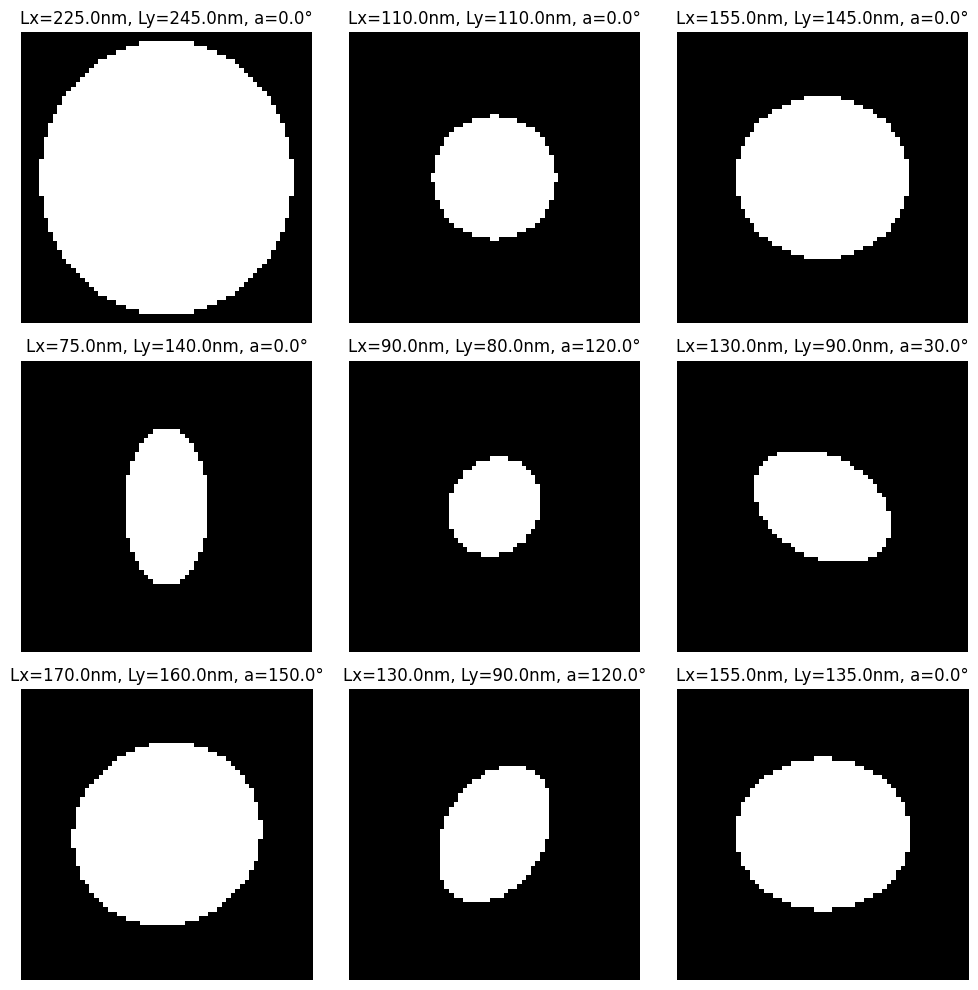


Processando Biblioteca de Retângulos...
Carregada: '/content/RETlib.pkl'. Forma inicial: (729, 52)
Filtrada para 2D. Nova forma: (729, 54)
Colunas 'L_x'/'L_y' de RETlib renomeadas para 'X'/'Y'.

Processando Biblioteca de Polígonos...
Carregada: '/content/Novas_Geometrias.pkl'. Forma inicial: (1085, 49)
Filtrada para 2D (H=600). Nova forma: (1085, 51)
Colunas de polígono 'a' e 'R_l' renomeadas para 'a_deg' e 'R_nm'.
Rodando verificação visual dos polígonos...
Verificando 9 amostras de desenhos de polígonos...


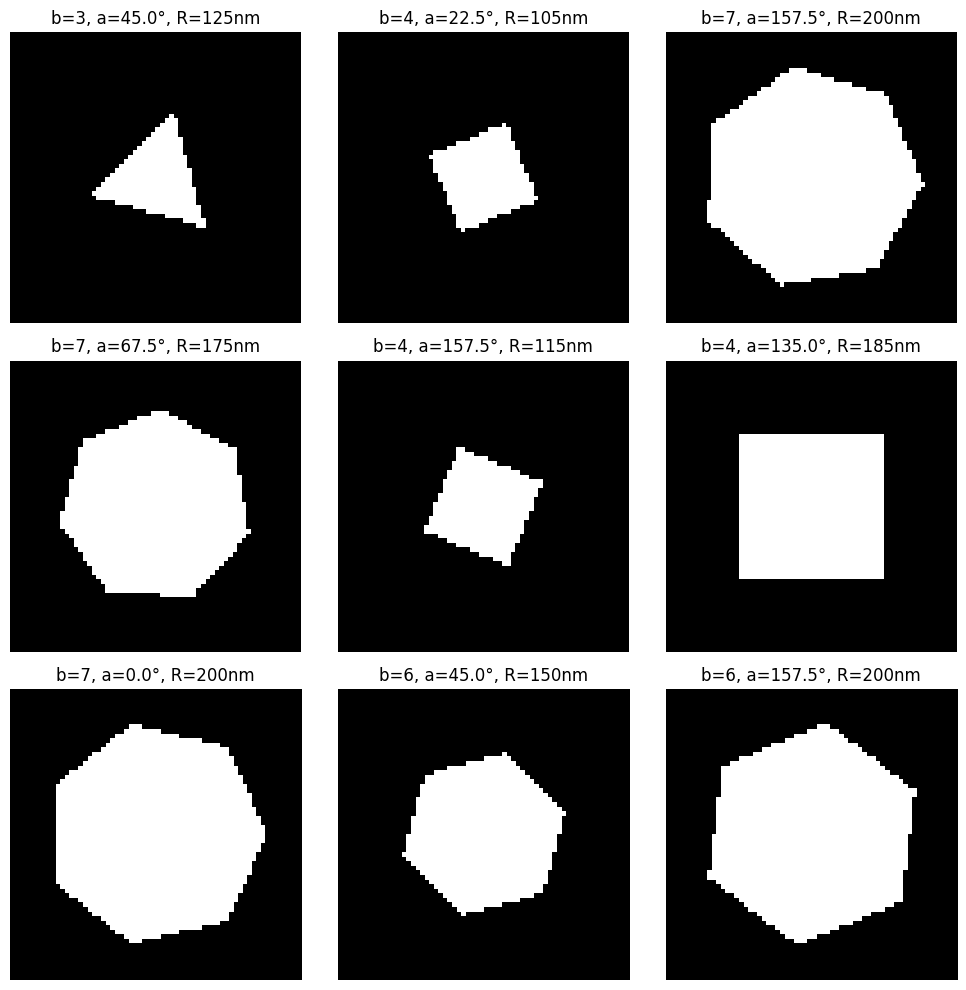

Gerando imagens de elipse...
2979 imagens de elipse adicionadas.
Gerando imagens de retângulo...
729 imagens de retângulo adicionadas.
Gerando imagens de polígono...
1085 imagens de polígono adicionadas.

--- PREPARAÇÃO DE DADOS CONCLUÍDA ---
Total de 4793 imagens geradas.
Total de 4793 alvos combinados.

Plotando 50 amostras aleatórias do dataset real...


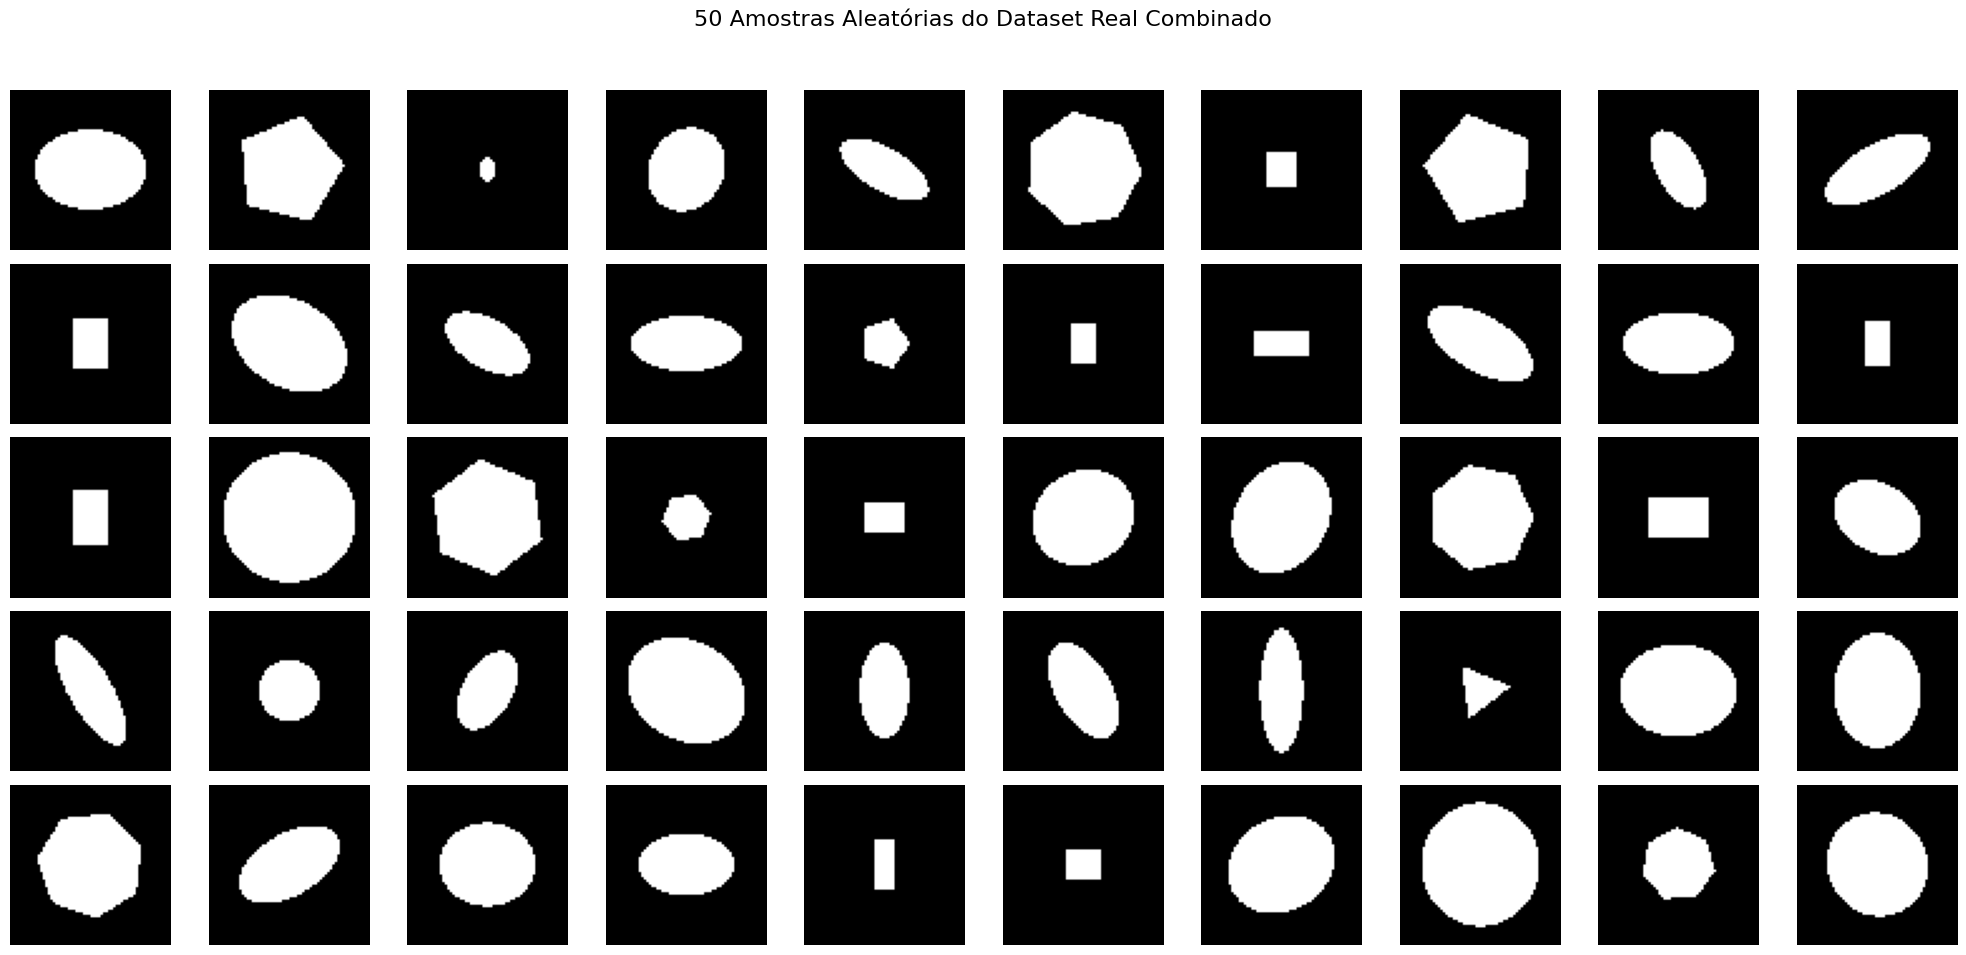

In [22]:
# --- CAMINHOS PARA OS ARQUIVOS ---
caminho_elipse_pkl = "/content/7lib.pkl"
caminho_ret_pkl = "/content/RETlib.pkl"
caminho_poligonos_pkl = "/content/Novas_Geometrias.pkl"

# --- 1. Processar Elipses (com rotação) ---
print("Processando Biblioteca de Elipses...")
df_ellipses = processar_elipses_pkl(caminho_elipse_pkl) # Usa a função NOVA
if df_ellipses is not None:
    # --- VERIFICAÇÃO VISUAL (ELIPSES) ---
    print("Rodando verificação visual das elipses...")
    verificar_desenhos_elipses(df_ellipses)

# --- 2. Processar Retângulos (sem rotação) ---
print("\nProcessando Biblioteca de Retângulos...")
df_rects = processar_pkl(caminho_ret_pkl) # Usa a função ANTIGA (com filtro a=0)
if df_rects is not None:
     df_rects = df_rects.rename(columns={'L_x': 'X', 'L_y': 'Y'})
     print("Colunas 'L_x'/'L_y' de RETlib renomeadas para 'X'/'Y'.")

# --- 3. Processar Polígonos (com rotação) ---
print("\nProcessando Biblioteca de Polígonos...")
df_polygons = processar_poligonos_pkl(caminho_poligonos_pkl) # Usa a função NOVA

if df_polygons is not None:
    try:
        # Apenas renomeia as colunas (a coluna 'a' já está em graus)
        df_polygons = df_polygons.rename(columns={'a': 'a_deg', 'R_l': 'R_nm'})
        print(f"Colunas de polígono 'a' e 'R_l' renomeadas para 'a_deg' e 'R_nm'.")

        # --- VERIFICAÇÃO VISUAL (POLÍGONOS) ---
        print("Rodando verificação visual dos polígonos...")
        verificar_desenhos_poligonos(df_polygons)

    except KeyError as e:
        print(f"--- ERRO: Coluna não encontrada no 'Novas_Geometrias.pkl' ---")
        print(f"Verifique os nomes 'a' ou 'R_l'. Erro: {e}")
        df_polygons = None
else:
    print("--- AVISO: DataFrame de polígonos não foi carregado. ---")


# --- 4. Juntar todos os dados para o Treinamento ---
all_images = []
all_targets_list = []
target_cols = ['Transmitancia_x', 'Transmitancia_y', 'Fase_x', 'Fase_y']

# 1. Adicionar Elipses
if df_ellipses is not None:
    print("Gerando imagens de elipse...")
    for index, row in df_ellipses.iterrows():
        # Passa L_x, L_y, e a rotação 'a'
        all_images.append(draw_meta_atom_ellipse(row['L_x'], row['L_y'], row['a']))
    all_targets_list.append(df_ellipses[target_cols].values)
    print(f"{len(df_ellipses)} imagens de elipse adicionadas.")

# 2. Adicionar Retângulos
if df_rects is not None:
    print("Gerando imagens de retângulo...")
    for index, row in df_rects.iterrows():
        all_images.append(draw_meta_atom_rectangle(row['X'], row['Y']))
    all_targets_list.append(df_rects[target_cols].values)
    print(f"{len(df_rects)} imagens de retângulo adicionadas.")

# 3. Adicionar Polígonos
if df_polygons is not None:
    print("Gerando imagens de polígono...")
    for index, row in df_polygons.iterrows():
        img = draw_meta_atom_polygon(int(row['b']), row['a_deg'], row['R_nm'])
        all_images.append(img)
    all_targets_list.append(df_polygons[target_cols].values)
    print(f"{len(df_polygons)} imagens de polígono adicionadas.")

# # --- 5. Concatenação Final ---
# if all_targets_list:
#     targets = np.concatenate(all_targets_list, axis=0).astype(np.float32)
#     print(f"\n--- PREPARAÇÃO DE DADOS CONCLUÍDA ---")
#     print(f"Total de {len(all_images)} imagens geradas.")
#     print(f"Total de {len(targets)} alvos combinados.")

#     # Limpa a memória
#     del all_targets_list
#     del df_ellipses, df_rects, df_polygons

# else:
#     print("\n--- ERRO ---")
#     print("Nenhum DataFrame foi carregado com sucesso. Verifique os caminhos e erros.")
# --- 5. Concatenação Final ---
if all_targets_list:
    targets = np.concatenate(all_targets_list, axis=0).astype(np.float32)
    print(f"\n--- PREPARAÇÃO DE DADOS CONCLUÍDA ---")
    print(f"Total de {len(all_images)} imagens geradas.")
    print(f"Total de {len(targets)} alvos combinados.")


    # --- INÍCIO DO NOVO CÓDIGO DE VISUALIZAÇÃO ---
    import random
    import matplotlib.pyplot as plt

    print("\nPlotando 50 amostras aleatórias do dataset real...")

    N_SAMPLES_REAL = 50
    num_to_plot = min(N_SAMPLES_REAL, len(all_images))

    # Seleciona 50 índices aleatórios da lista de imagens
    random_indices = random.sample(range(len(all_images)), num_to_plot)

    plt.figure(figsize=(20, 10)) # 5 linhas, 10 colunas
    plt.suptitle("50 Amostras Aleatórias do Dataset Real Combinado", fontsize=16)

    for i, idx in enumerate(random_indices):
        img_np = all_images[idx] # Pega a imagem da lista

        plt.subplot(5, 10, i + 1)
        plt.imshow(img_np, cmap='gray')
        plt.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    # --- FIM DO NOVO CÓDIGO DE VISUALIZAÇÃO ---


    # Limpa a memória (código original)
    del all_targets_list
    del df_ellipses, df_rects, df_polygons

else:
    print("\n--- ERRO ---")
    print("Nenhum DataFrame foi carregado com sucesso. Verifique os caminhos e erros.")

Fazer um adaptador de dados para o PyTorch. Ele pega suas listas de dados brutos e os "empacota" um por um, convertendo-os no formato exato que o PyTorch entende (Tensores) para que possam ser usados no treinamento do modelo.

In [8]:
class MetaAtomDataset(Dataset):
    """
    Dataset que carrega imagens de meta-átomos e seus alvos ópticos.
    """

    def __init__(self, images_list, targets_array, transform=None):

        self.images = images_list
        self.targets = targets_array
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        target = self.targets[idx]

        image = np.expand_dims(image, axis=0)

        # Converte para tensor
        image = torch.from_numpy(image)
        target = torch.from_numpy(target)

        if self.transform:
            image = self.transform(image)

        return image, target

Preparar os dados para o treinamento. Agrupa todos os dados brutos em um único dataset, divide em dois conjuntos: 80% para treino e 20% para validação.

Cria dois "alimentadores" (DataLoader) que entregam esses dados em lotes (batches) para a rede neural, um para treinar (train_loader) e outro para validar (val_loader).

In [9]:
dataset = MetaAtomDataset(all_images, targets, transform=None)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# CPPN e GAN:

Componentes de entrada e ativação para o Gerador CPPN:

In [10]:
class Sin(nn.Module):
    def forward(self, x): return torch.sin(x)

class Gaussian(nn.Module):
    def forward(self, x): return torch.exp(-x**2)

def make_coordinate_grid(size, device='cpu'):
    """Cria grade de coordenadas (x, y)"""
    xs = np.linspace(-1, 1, size)
    ys = np.linspace(-1, 1, size)
    xx, yy = np.meshgrid(xs, ys)

    coords = np.stack([xx.ravel(), yy.ravel()], axis=-1).astype(np.float32)
    return torch.from_numpy(coords).to(device) # shape (size*size, 2)

# def make_coordinate_grid_with_r(size, device='cpu'):
#     """
#     Cria grade de coordenadas (x, y, r).
#     """
#     xs = np.linspace(-1, 1, size)
#     ys = np.linspace(-1, 1, size)
#     xx, yy = np.meshgrid(xs, ys)

#     # r = sqrt(x^2 + y^2) [fonte: 140]
#     rr = np.sqrt(xx**2 + yy**2)

#     # Stack (x, y, r)
#     coords = np.stack([xx.ravel(), yy.ravel(), rr.ravel()], axis=-1).astype(np.float32)
#     return torch.from_numpy(coords).to(device) # shape (size*size, 3)

Define a arquitetura do gerador (CPPN):

In [11]:
class CPPN_Generator(nn.Module):
    """
    Gerador CPPN. Mapeia (vetor latente 'v' + coords 'x,y,r') -> pixel.
    """
    # def __init__(self, latent_dim, in_coords=2, out_channels=1, hidden_dim=32):
    #     super().__init__()
    #     self.latent_dim = latent_dim
    #     self.in_coords = in_coords

    #     self.out_channels = out_channels

    #     input_dim = in_coords + latent_dim

    #     self.net = nn.Sequential(
    #         nn.Linear(input_dim, hidden_dim),
    #         nn.Tanh(),
    #         nn.Linear(hidden_dim, hidden_dim),
    #         Sin(),
    #         nn.Linear(hidden_dim, hidden_dim),
    #         Gaussian(),
    #         nn.Linear(hidden_dim, hidden_dim),
    #         nn.Tanh(),
    #         nn.Linear(hidden_dim, out_channels),
    #         nn.Sigmoid()
    #     )
    def __init__(self, latent_dim, in_coords=2, out_channels=1, hidden_dim=64):
            super().__init__()
            self.latent_dim = latent_dim
            self.in_coords = in_coords
            self.out_channels = out_channels

            input_dim = in_coords + latent_dim

            self.net = nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.Tanh(),

                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),

                nn.Linear(hidden_dim, hidden_dim),
                Sin(),

                nn.Linear(hidden_dim, hidden_dim),
                nn.LeakyReLU(0.2),

                nn.Linear(hidden_dim, hidden_dim),
                Gaussian(),

                nn.Linear(hidden_dim, hidden_dim),
                nn.Tanh(),

                nn.Linear(hidden_dim, hidden_dim),
                Sin(),

                nn.Linear(hidden_dim, hidden_dim),
                Gaussian(),

                nn.Linear(hidden_dim, hidden_dim),
                nn.Tanh(),

                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),

                nn.Linear(hidden_dim, hidden_dim),
                Sin(),

                nn.Linear(hidden_dim, out_channels),
                nn.Sigmoid()
            )

    def forward(self, coords, v):

        v_expanded = v.unsqueeze(1)
        v_tiled = v_expanded.repeat(1, coords.size(0), 1)

        coords_tiled = coords.unsqueeze(0).repeat(v.size(0), 1, 1)

        combined_input = torch.cat([coords_tiled, v_tiled], dim=-1)

        output = self.net(combined_input)

        img_size = int(np.sqrt(coords.size(0)))

        output = output.permute(0, 2, 1).view(-1, self.out_channels, img_size, img_size)

        return output

Definer o Crítico/Discriminador, a rede neural adversária da GAN. A função dele é olhar para uma imagem de meta-átomo, seja uma real do seu dataset ou uma "falsa" do CPPN_Generator, e dar uma nota que avalia o quão "real" ela parece ser. Ele é uma Rede Neural Convolucional (CNN).

In [12]:
# class CriticCNN(nn.Module):
#     """
#     Crítico (Discriminador).
#     """
#     def __init__(self, in_channels=1):
#         super().__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(in_channels, 16, 4, stride=2, padding=1),
#             nn.LeakyReLU(0.2),
#             nn.Conv2d(16, 32, 4, stride=2, padding=1),
#             nn.LeakyReLU(0.2),
#             nn.Conv2d(32, 64, 4, stride=2, padding=1),
#             nn.LeakyReLU(0.2),
#             nn.Conv2d(64, 128, 4, stride=2, padding=1),
#             nn.LeakyReLU(0.2),
#         )

#         self.head = nn.Linear(128 * 4 * 4, 1)

#     def forward(self, x):
#         f = self.features(x)
#         f = f.view(x.size(0), -1)
#         return self.head(f)

class CriticCNN(nn.Module):
    def __init__(self, in_channels=1):
        super().__init__()
        self.features = nn.Sequential(
            # Comece com 32 ou 64 filtros, em vez de 16
            nn.Conv2d(in_channels, 32, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, stride=2, padding=1), # Pode aumentar aqui também
            nn.LeakyReLU(0.2),
        )

        # Ajuste a camada Linear para o novo tamanho
        self.head = nn.Linear(256 * 4 * 4, 1) # 256 * 4 * 4

    def forward(self, x):
        f = self.features(x)
        f = f.view(x.size(0), -1)
        return self.head(f)

Penalidade de Gradiente (WGAN-GP), treinamento de Redes Adversariais Gerativas (GANs):

In [13]:
def compute_gradient_penalty(critic, real_samples, fake_samples, device):
    """
    Calcula a penalidade de gradiente (WGAN-GP).
    """
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=device)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)

    critic_interpolates = critic(interpolates)

    gradients = torch.autograd.grad(
        outputs=critic_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(critic_interpolates, device=device),
        create_graph=True,
        retain_graph=True,
    )[0]

    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

Função principal de treinamento da Rede Adversarial Gerativa (GAN). O objetivo dela é treinar o CPPN_Generator para que ele aprenda a desenhar imagens de meta-átomos que sejam indistinguíveis das suas imagens reais vindas do DataFrame.

In [14]:
class MetaAtomImageDataset(Dataset):
    """
    Dataset que carrega apenas as imagens de meta-átomos.
    """

    def __init__(self, images_list):
        self.images = images_list

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        image = np.expand_dims(image, axis=0)
        return torch.from_numpy(image)

def train_cppn_gan(all_images_numpy, device):
    """
    Função principal para treinar a CPPN-GAN.
    """
    # Hiperparâmetros baseados no Artigo
    LATENT_DIM = 128
    BATCH_SIZE = 64
    LR = 0.0001
    BETA1 = 0.5
    BETA2 = 0.9
    N_CRITIC = 5
    EPOCHS = 3500
    LAMBDA_GP = 5

    dataset = MetaAtomImageDataset(all_images_numpy)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

    coords_grid = make_coordinate_grid(IMG_SIZE, device=device)

    generator = CPPN_Generator(latent_dim=LATENT_DIM).to(device)
    critic = CriticCNN(in_channels=1).to(device)

    optimizer_G = optim.Adam(generator.parameters(), lr=LR, betas=(BETA1, BETA2))
    optimizer_D = optim.Adam(critic.parameters(), lr=LR, betas=(BETA1, BETA2))

    data_transform = transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 1.0))

    print("Iniciando treinamento da CPPN-GAN...")

    for epoch in range(EPOCHS):
        for i, real_images in enumerate(dataloader):
            real_images = real_images.to(device)
            real_images = data_transform(real_images)
            current_batch_size = real_images.size(0)

            optimizer_D.zero_grad()

            z = torch.randn(current_batch_size, LATENT_DIM, device=device)
            with torch.no_grad():
                fake_images = generator(coords_grid, z)

            real_score = critic(real_images)
            fake_score = critic(fake_images)

            gp = compute_gradient_penalty(critic, real_images, fake_images, device)

            loss_D = fake_score.mean() - real_score.mean() + LAMBDA_GP * gp

            loss_D.backward()
            optimizer_D.step()

            if (i + 1) % N_CRITIC == 0:
                optimizer_G.zero_grad()

                z = torch.randn(current_batch_size, LATENT_DIM, device=device)
                fake_images_for_G = generator(coords_grid, z)

                fake_score_for_G = critic(fake_images_for_G)

                loss_G = -fake_score_for_G.mean()

                loss_G.backward()
                optimizer_G.step()

        print(f"Epoch [{epoch+1}/{EPOCHS}], "
              f"Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}")
    return generator

Executar o Script:

In [26]:
if __name__ == '__main__':

    start_time = time.time()

    if 'all_images' not in locals() or len(all_images) == 0:
        print("Erro: A lista 'all_images' não foi encontrada ou está vazia.")

    else:
        print(f"{len(all_images)} imagens reais prontas.")

        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print(f"Usando dispositivo: {device}")

        trained_generator = train_cppn_gan(all_images, device=device)

        print("Pré-computação concluída.")

    end_time = time.time()
    total_time = end_time - start_time
    minutos = total_time / 60

    print(f"\nTempo total de execução: {total_time:.2f} segundos ({minutos:.2f} minutos).")

4793 imagens reais prontas.
Usando dispositivo: cuda
Iniciando treinamento da CPPN-GAN...
Epoch [1/3500], Loss D: -51.5403, Loss G: 35.2827
Epoch [2/3500], Loss D: -65.6562, Loss G: -25.3043
Epoch [3/3500], Loss D: -62.1191, Loss G: -50.9876
Epoch [4/3500], Loss D: -58.6932, Loss G: -52.9102
Epoch [5/3500], Loss D: -54.8977, Loss G: -46.3518
Epoch [6/3500], Loss D: -48.6084, Loss G: -42.9332
Epoch [7/3500], Loss D: -51.2360, Loss G: -41.1189
Epoch [8/3500], Loss D: -53.6305, Loss G: -34.0715
Epoch [9/3500], Loss D: -44.5552, Loss G: -28.0923
Epoch [10/3500], Loss D: -49.2346, Loss G: -21.0200
Epoch [11/3500], Loss D: -51.0870, Loss G: -18.0162
Epoch [12/3500], Loss D: -54.4680, Loss G: -16.0445
Epoch [13/3500], Loss D: -49.8121, Loss G: -19.3092
Epoch [14/3500], Loss D: -45.1724, Loss G: -19.8828
Epoch [15/3500], Loss D: -52.1492, Loss G: -18.0644
Epoch [16/3500], Loss D: -55.0592, Loss G: -18.0410
Epoch [17/3500], Loss D: -52.9814, Loss G: -18.3431
Epoch [18/3500], Loss D: -49.5969, L

In [29]:
GENERATOR_PATH = "generator_teste_5_final.pth"
torch.save(trained_generator.state_dict(), GENERATOR_PATH)

print(f"Treinamento da GAN concluído. Gerador salvo em {GENERATOR_PATH}")

Treinamento da GAN concluído. Gerador salvo em generator_teste_5_final.pth


# Verificar Treinamento

Modelo '/content/generator_teste_5_final.pth' carregado com sucesso.
Amostras geradas. Plotando...


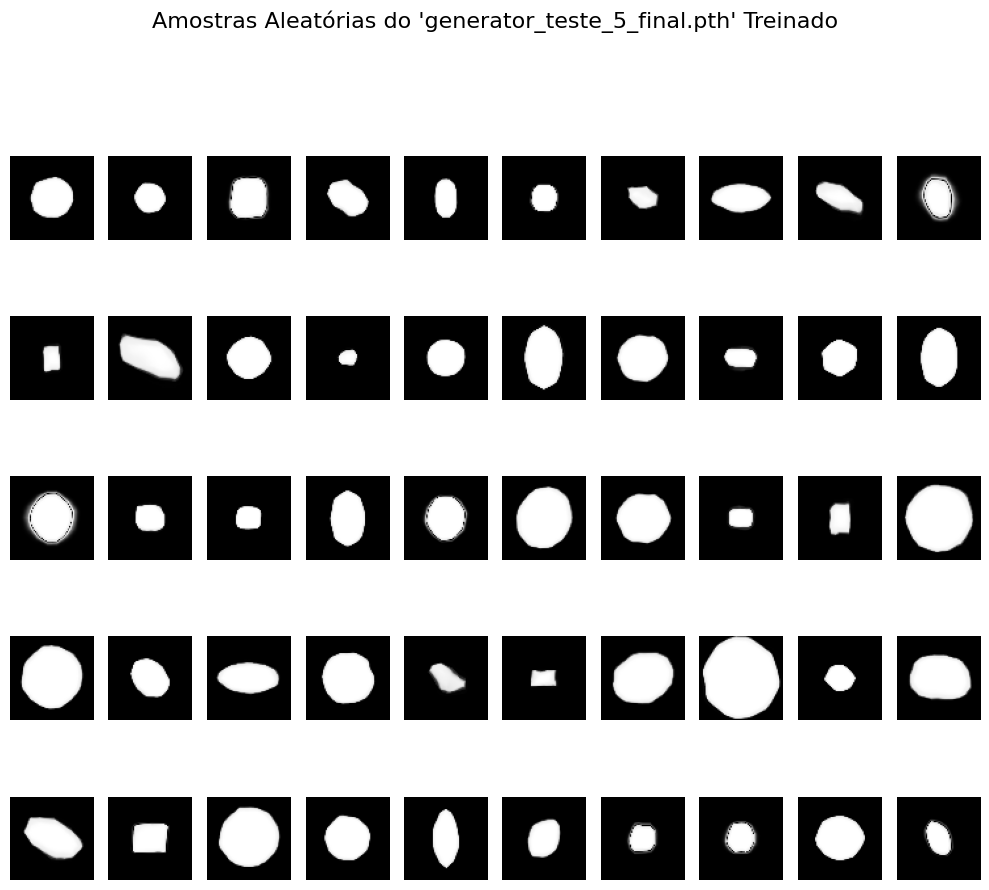

In [18]:
LATENT_DIM = 128
IMG_SIZE = 64
N_SAMPLES = 50
GENERATOR_PATH = "/content/generator_teste_5_final.pth"

device = 'cuda' if torch.cuda.is_available() else 'cpu'

try:
    generator = CPPN_Generator(latent_dim=LATENT_DIM).to(device)
    generator.load_state_dict(torch.load(GENERATOR_PATH, map_location=device))
    generator.eval()
    print(f"Modelo '{GENERATOR_PATH}' carregado com sucesso.")
except FileNotFoundError:
    print(f"ERRO: Arquivo '{GENERATOR_PATH}' não encontrado.")
    print("Certifique-se de que a célula de treinamento da GAN [Ko3UYXB1DJ7l] foi executada.")
except Exception as e:
    print(f"Erro ao carregar o modelo: {e}")

coords_grid = make_coordinate_grid(IMG_SIZE, device=device)

z = torch.randn(N_SAMPLES, LATENT_DIM, device=device)

with torch.no_grad():
    # Gerar 25 imagens
    images = generator(coords_grid, z)
    # images_binary = (images > 0.5).float()

print("Amostras geradas. Plotando...")

plt.figure(figsize=(10, 10))
plt.suptitle("Amostras Aleatórias do 'generator_5_final.pth' Treinado", fontsize=16)

for i in range(N_SAMPLES):
    # Use a variável 'images' (saída bruta) aqui
    img_np = images[i].squeeze().cpu().numpy()

    plt.subplot(5, 10, i + 1)
    # Adicionar vmin=0 e vmax=1 ajuda a ver a escala de cinza
    plt.imshow(img_np, cmap='gray', vmin=0, vmax=1)
    plt.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Modelo '/content/generator_teste_5_final.pth' carregado com sucesso.
Amostras BINARIZADAS geradas. Plotando...


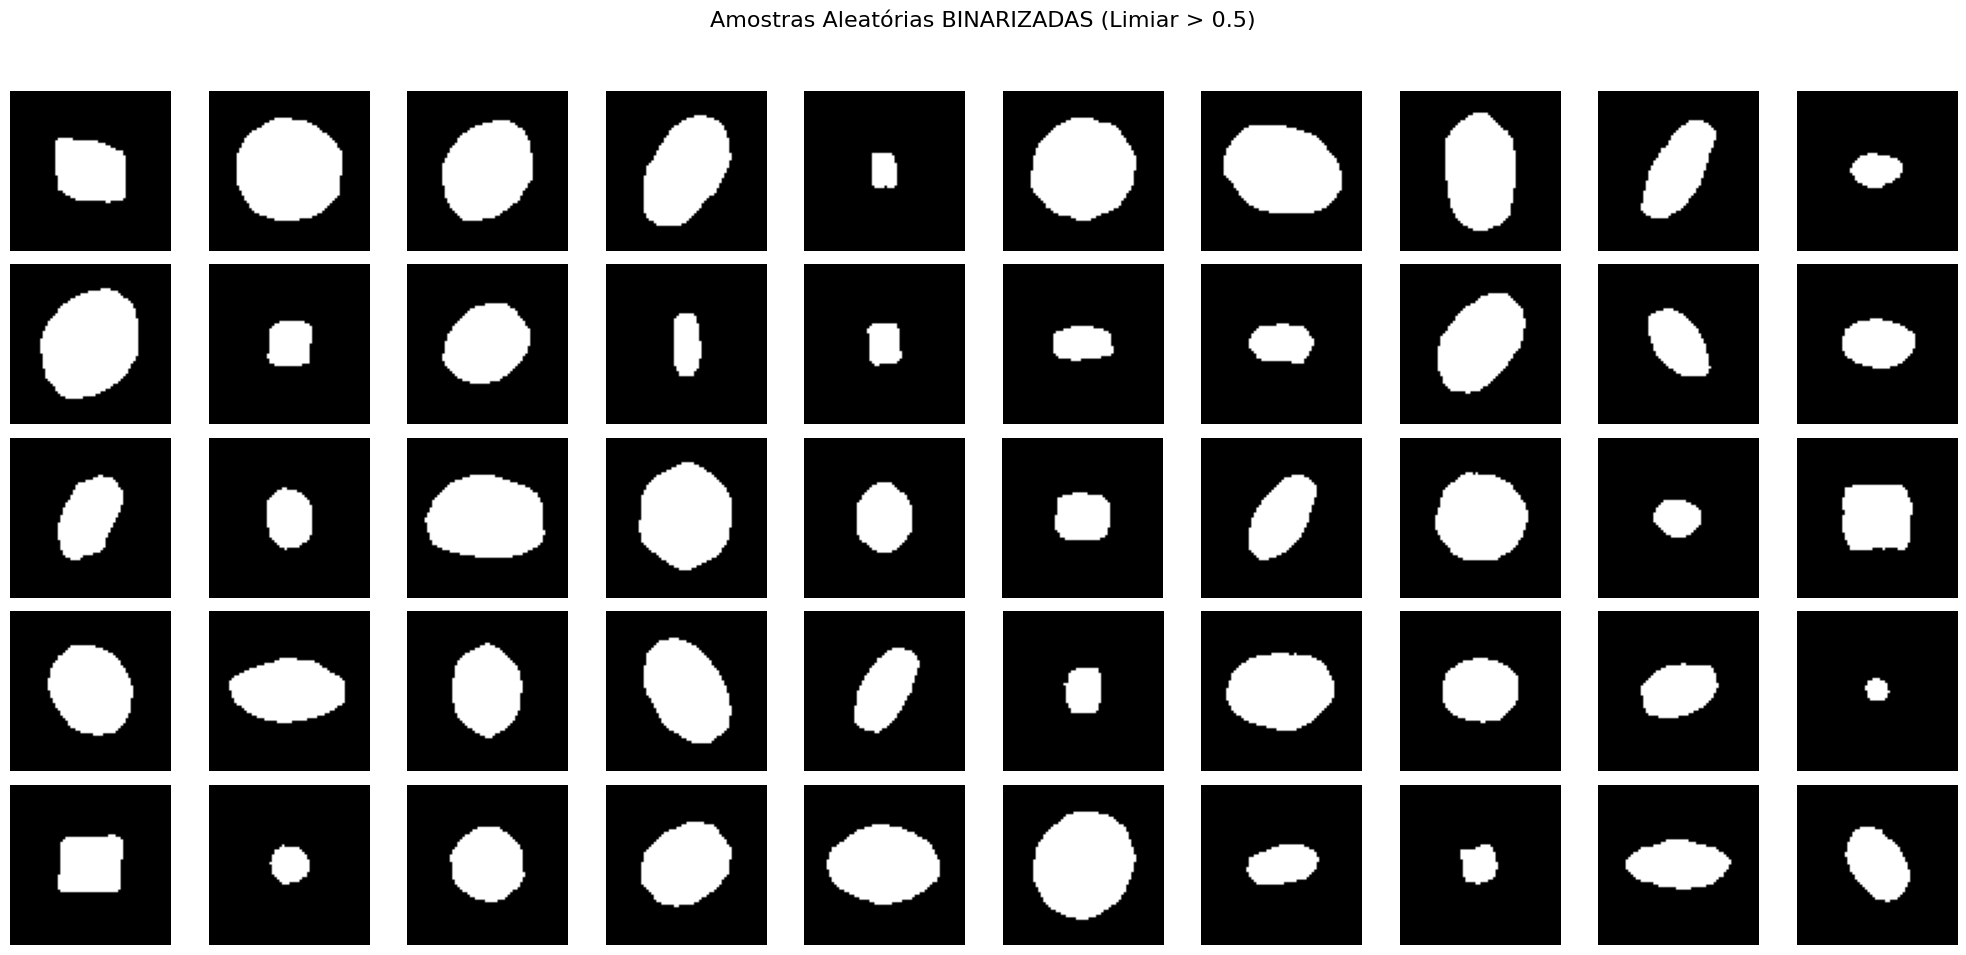

In [21]:
LATENT_DIM = 128
IMG_SIZE = 64
N_SAMPLES = 50
GENERATOR_PATH = "/content/generator_teste_5_final.pth"

device = 'cuda' if torch.cuda.is_available() else 'cpu'

try:
    generator = CPPN_Generator(latent_dim=LATENT_DIM, in_coords=2).to(device)
    generator.load_state_dict(torch.load(GENERATOR_PATH, map_location=device))
    generator.eval()
    print(f"Modelo '{GENERATOR_PATH}' carregado com sucesso.")
except FileNotFoundError:
    print(f"ERRO: Arquivo '{GENERATOR_PATH}' não encontrado.")
except Exception as e:
    print(f"Erro ao carregar o modelo: {e}")

coords_grid = make_coordinate_grid(IMG_SIZE, device=device)
z = torch.randn(N_SAMPLES, LATENT_DIM, device=device)

with torch.no_grad():
    images = generator(coords_grid, z)
    # --- MUDANÇA AQUI ---
    # Descomente esta linha para aplicar o limiar (binarizar)
    images_binary = (images > 0.5).float()

print("Amostras BINARIZADAS geradas. Plotando...")

plt.figure(figsize=(20, 10))
plt.suptitle("Amostras Aleatórias BINARIZADAS (Limiar > 0.5)", fontsize=16)

for i in range(N_SAMPLES):
    # --- MUDANÇA AQUI ---
    # Use a variável 'images_binary'
    img_np = images_binary[i].squeeze().cpu().numpy()

    plt.subplot(5, 10, i + 1)

    # Não precisamos mais de vmin/vmax, pois é 0 ou 1
    plt.imshow(img_np, cmap='gray')
    plt.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()